In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

2.2.0


In [2]:
df=pd.read_csv("data_sin_tipocambio.csv")
df.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,BCHAIN-MKPRU (USD)
0,2015-01-15,43.80,3112.370,45.670,16872.95,1380.00,48.60,4.12,2013.750,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,218.11
1,2015-01-16,43.26,3147.530,45.730,16812.96,1404.90,46.35,4.12,1992.250,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,205.35
2,2015-01-17,43.26,3147.530,45.730,16812.96,1342.95,47.65,4.12,1992.250,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,197.12
3,2015-01-18,43.26,3178.075,45.730,16906.87,1281.00,48.95,4.12,1992.250,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,211.18
4,2015-01-19,44.13,3208.620,46.165,17000.78,1279.40,48.84,4.12,2006.505,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,212.39


## Graficamos el historial del bitcoin desde el 2018 hasta la fecha

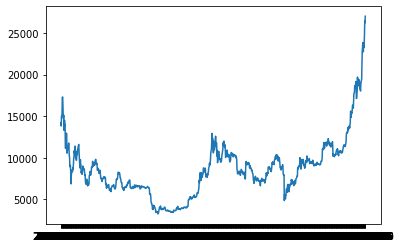

In [3]:
plt.plot(df.iloc[1082:,0], df.iloc[1082:,-1])

## Funcion para obtener ventanas a partir del dataframe (hay que pensar si nos lo rapiñamos o solo decimos de donde lo sacamos)

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg





## Definimos los  hiperparemetros y estandarizamos nuestros datos

In [5]:
ventana=3 # Se puede mover 
n_cols=15 # Numero de variables incluyendo la variable objetivo
entrenamiento=800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
n_obs=ventana*n_cols

In [6]:

values = df.iloc[1082:,1:].values# Desde el primer dia del 2018

transformer = StandardScaler()
transformer.fit(values)

transformer_y = StandardScaler()
transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

values = transformer.transform(values)
data = series_to_supervised(values, ventana,1 )

### Visualizamos el data frame de ventanas

In [7]:
data.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
3,1.161484,0.866946,-1.378602,0.528529,-1.038526,0.499388,0.477602,-0.718423,-1.813396,-0.066545,...,0.872874,0.035328,-0.974776,-1.802392,0.077947,4.423236,-1.540261,1.341660,3.707375,1.820202
4,1.161484,1.061030,-1.266617,0.672790,-0.380414,0.849897,0.860906,-0.496031,-1.809849,-0.034426,...,1.145881,-0.230036,-1.099826,-1.798572,0.079569,4.932414,-1.512628,1.359982,4.799380,1.861608
5,1.161484,0.275754,-1.222589,-0.219471,-0.565139,0.599867,0.035328,-0.849727,-1.805961,-0.044657,...,1.029824,-0.495401,-0.837567,-1.795321,0.088724,4.765112,-1.575431,1.045032,3.249554,2.421299
6,1.161484,0.500245,-0.998939,-0.040272,-0.564194,0.872874,0.035328,-0.974776,-1.802392,0.077947,...,1.082790,-0.672310,-0.658553,-1.791501,0.022579,5.696160,-1.512628,0.429209,3.256040,2.462417
7,1.161484,0.724736,-0.775289,0.138927,-0.563249,1.145881,-0.230036,-1.099826,-1.798572,0.079569,...,1.135755,-0.849220,-0.479539,-1.787818,-0.012308,5.159285,-1.527701,0.752450,3.450862,2.273169


### Creamos nuestro conjunto train y test con sus respectivos X y Y variables

In [8]:
train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(800, 45) (800,)
(292, 45) (292,)


### Modificamos las dimensiones del train y test para que tengan un formato:
(muestras, ventana, numero de variables)

In [9]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

## Creacion del modelo

In [10]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[train_X.shape[1],train_X.shape[2]]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)

l_loss: 0.5803 - val_mae: 0.9750
Epoch 852/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0260 - mae: 0.1747 - val_loss: 0.5799 - val_mae: 0.9746
Epoch 853/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.1796 - val_loss: 0.5800 - val_mae: 0.9747
Epoch 854/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.1754 - val_loss: 0.5798 - val_mae: 0.9745
Epoch 855/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0259 - mae: 0.1778 - val_loss: 0.5798 - val_mae: 0.9745
Epoch 856/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0241 - mae: 0.1725 - val_loss: 0.5800 - val_mae: 0.9746
Epoch 857/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0255 - mae: 0.1754 - val_loss: 0.5800 - val_mae: 0.9746
Epoch 858/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0232 - mae: 0.1694 - val_loss: 0.5798 - val_mae: 0.9744
Epoch 859/1000
25/25 [=======

## Graficamos la funcion de perdida del trainning vs el test

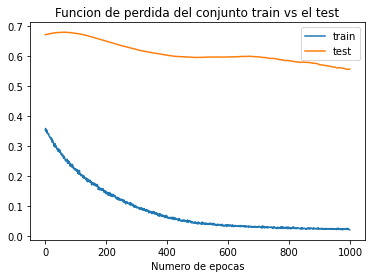

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Funcion de perdida del conjunto train vs el test")
plt.xlabel("Numero de epocas")
plt.show()


### Predecimos el test y lo graficamos con respecto al valor real

In [19]:
y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5, 0, 'Numero de dias')

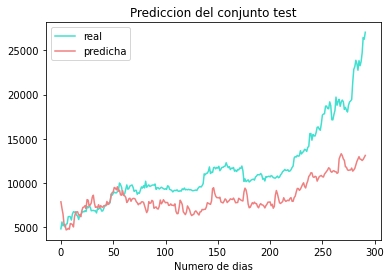

In [20]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

### Predecimos el train y lo graficamos con respecto al valor real

In [21]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos

Text(0.5, 0, 'Numero de dias')

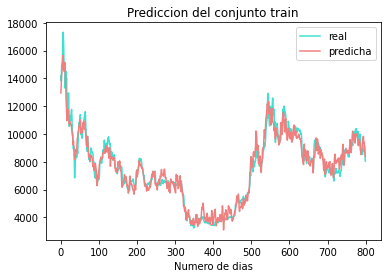

In [22]:
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")

In [16]:
 #model.save('modelo_3-norm.h5')

In [18]:
#model=load_model("modelo_3-norm.h5")